In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import pylab as pp
import numpy as np
import scipy as sp

from sklearn.preprocessing import StandardScaler


# loading the datasets

In [3]:
trainData = []
testData = []
RUL = []
#names = ['unit', 'time']
names = ['unit', 'time']
names.extend([('op%d' %  j ) for j in range(1,4)])
names.extend([('sr%1d' % j) for j in range(1,22)])

for i in range(1,5):
    trainData.append(pd.read_table(('train_FD00%d.txt' % i),
                                  sep=' ',
                                  index_col=False,
                                  names=names,
                                  header = None,
                                  decimal='.',
                                  engine='python'))
    trainData[-1].set_index(['unit', 'time'],inplace=True)
    testData.append(pd.read_table(('test_FD00%d.txt' % i),
                                  sep=' ',
                                  index_col=False,
                                  names=names,
                                  header = None,
                                  decimal='.',
                                  engine='python'))
    testData[-1].set_index(['unit', 'time'],inplace=True)
    RUL.append(pd.read_table(('RUL_FD00%d.txt' % i),
                             sep=' ',
                             index_col=False,
                             names=['RULtime'],
                             header = None,
                             engine='python'))

    

* data are loaded in the Pandas DataFrames
* each DF contains data from the whole file
* DF has multiindex consisting of unit and time

* The datasets are organized in two separate lists, one for training datasets, second for the test datasets.
A given dataset number is respective of the position in the lists
The RUL data are also stored in the list.

Inconsitencies encauntered: 
* the readme file suggests 26 sensors, there are actually only 21 sensors
* the number 26 is the total count of columns

The data source:
* A. Saxena, K. Goebel, D. Simon and N. Eklund, "Damage propagation modeling for aircraft engine run-to-failure simulation," 2008 International Conference on Prognostics and Health Management, Denver, CO, 2008, pp. 1-9, doi: 10.1109/PHM.2008.4711414.

Previously treated in:
* M.L. Baptista et al. / Mechanical Systems and Signal Processing 146 (2021) 106987, https://doi.org/10.1016/j.ymssp.2020.106987
* 2008 International Conference on Prognostics and Health Management (competition)


## a quick peak at the data

In [4]:
trainData[0].head()

op1     op2    op3     sr1     sr2      sr3      sr4    sr5  \
unit time                                                                   
1    1    -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
     2     0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
     3    -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
     4     0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
     5    -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   

             sr6     sr7  ...    sr12     sr13     sr14    sr15  sr16  sr17  \
unit time                 ...                                                 
1    1     21.61  554.36  ...  521.66  2388.02  8138.62  8.4195  0.03   392   
     2     21.61  553.75  ...  522.28  2388.07  8131.49  8.4318  0.03   392   
     3     21.61  554.26  ...  522.42  2388.03  8133.23  8.4178  0.03   390   
     4     21.61  554.45  ...  522.86  2388.08  8133.83  8.3682  0.03   392   
     5     21.61  554.00  ...  522.19  2388.04  8133.80  8.4294  0.03   393   

           sr18   sr19   sr20     sr21  
unit time                               
1    1     2388  100.0  39.06  23.4190  
     2     2388  100.0  39.00  23.4236  
     3     2388  100.0  38.95  23.3442  
     4     2388  100.0  38.88  23.3739  
     5     2388  100.0  38.90  23.4044  

[5 rows x 24 columns]

In [5]:
trainData[0].loc[1,:].tail()

,op1,op2,op3,sr1,sr2,sr3,sr4,sr5,sr6,sr7,...,sr12,sr13,sr14,sr15,sr16,sr17,sr18,sr19,sr20,sr21
time,,,,,,,,,,,,,,,,,,,,,
188,-0.0067,0.0003,100.0,518.67,643.75,1602.38,1422.78,14.62,21.61,551.94,...,519.79,2388.23,8117.69,8.5207,0.03,396,2388,100.0,38.51,22.9588
189,-0.0006,0.0002,100.0,518.67,644.18,1596.17,1428.01,14.62,21.61,550.70,...,519.58,2388.33,8117.51,8.5183,0.03,395,2388,100.0,38.48,23.1127
190,-0.0027,0.0001,100.0,518.67,643.64,1599.22,1425.95,14.62,21.61,551.29,...,520.04,2388.35,8112.58,8.5223,0.03,398,2388,100.0,38.49,23.0675
191,-0.0000,-0.0004,100.0,518.67,643.34,1602.36,1425.77,14.62,21.61,550.92,...,519.57,2388.30,8114.61,8.5174,0.03,394,2388,100.0,38.45,23.1295
192,0.0009,-0.0000,100.0,518.67,643.54,1601.41,1427.20,14.62,21.61,551.25,...,520.08,2388.32,8110.93,8.5113,0.03,396,2388,100.0,38.48,22.9649


In [6]:
trainData[3].loc[2,:].tail()

,op1,op2,op3,sr1,sr2,sr3,sr4,sr5,sr6,sr7,...,sr12,sr13,sr14,sr15,sr16,sr17,sr18,sr19,sr20,sr21
time,,,,,,,,,,,,,,,,,,,,,
295,19.9982,0.7002,100.0,491.19,608.60,1501.41,1263.71,9.35,13.66,333.34,...,313.79,2388.27,8067.36,9.3213,0.03,368,2324,100.00,24.25,14.6146
296,20.0078,0.7000,100.0,491.19,608.93,1495.42,1278.71,9.35,13.66,333.63,...,314.26,2388.35,8076.25,9.2883,0.03,368,2324,100.00,24.43,14.5192
297,24.9993,0.6205,60.0,462.54,537.21,1264.64,1070.69,7.05,9.03,174.94,...,163.82,2028.42,7885.78,11.0337,0.02,308,1915,84.93,14.09,8.5068
298,20.0008,0.7000,100.0,491.19,608.17,1499.21,1270.03,9.35,13.66,333.22,...,313.79,2388.37,8066.76,9.3526,0.03,368,2324,100.00,24.18,14.5013
299,42.0006,0.8407,100.0,445.00,550.21,1375.30,1150.95,3.91,5.72,138.21,...,129.94,2388.03,8090.70,9.4679,0.02,335,2212,100.00,10.45,6.2911


# graphical data presentation

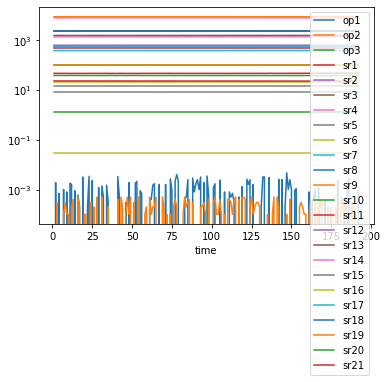

In [7]:
trainData[0].loc[1,:].plot(logy=True)

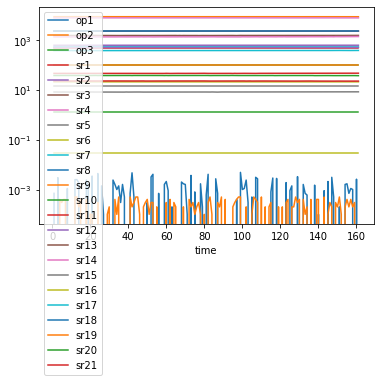

In [8]:
trainData[2].loc[50,:].plot(logy=True)

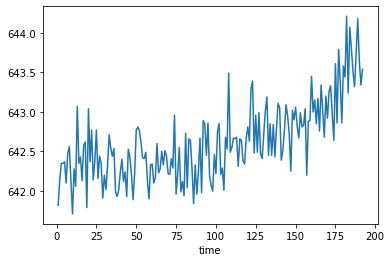

In [9]:
trainData[0].loc[1,'sr2'].plot()

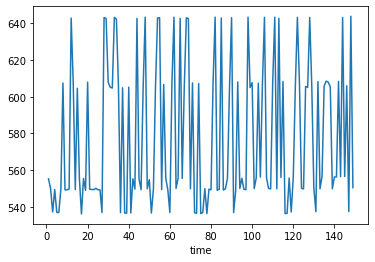

In [10]:
trainData[1].loc[1,'sr2'].plot()

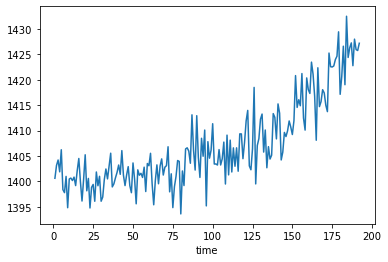

In [11]:
trainData[0].loc[(1),'sr4'].plot()

## statistical description of the data


Data Set: FD001
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: ONE (HPC Degradation)

Data Set: FD002
Train trjectories: 260
Test trajectories: 259
Conditions: SIX 
Fault Modes: ONE (HPC Degradation)

Data Set: FD003
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: TWO (HPC Degradation, Fan Degradation)

Data Set: FD004
Train trjectories: 248
Test trajectories: 249
Conditions: SIX 
Fault Modes: TWO (HPC Degradation, Fan Degradation)


In [12]:
#  metadata from file readme.txt
FD001 = {"Data Set Name": "FD001",
         "idx" : 0,
         "Train trjectories:": 100,
         "Test trajectories:" : 100,
         "Conditions": 1,
         "Conditions name" : "Sea Level",
         "Fault Modes": 1,
         "Fault Modes name": "HPC Degradation"}

FD002 = {"Data Set Name": "FD002",
         "idx" : 1,
         "Train trjectories:": 260,
         "Test trajectories:" : 259,
         "Conditions": 6,
         "Conditions name" : "",
         "Fault Modes": 1,
         "Fault Modes name": "HPC Degradation"}

FD003 = {"Data Set Name": "FD003",
         "idx" : 2,
         "Train trjectories:": 100,
         "Test trajectories:" : 100,
         "Conditions": 1,
         "Conditions name" : "Sea Level",
         "Fault Modes": 2,
         "Fault Modes name": ["HPC Degradation", "Fan Degradation"]}

FD004 = {"Data Set Name": "FD004",
         "idx" : 3,
         "Train trjectories:": 249,
         "Test trajectories:" : 248,
         "Conditions": 6,
         "Conditions name" : "",
         "Fault Modes": 2,
         "Fault Modes name": ["HPC Degradation", "Fan Degradation"]}

meta = [FD001,FD002,FD003,FD004]


In [13]:
# FD001['train_stats'] = trainData[FD001['idx']].describe().T
for i in range(len(meta)):
    meta[i]['train_stats'] = trainData[FD001['idx']].describe().T

In [14]:
FD004['train_stats'] 

,count,mean,std,min,25%,50%,75%,max
op1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
op2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
op3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
sr1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
sr2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
sr3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
sr4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
sr5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200
sr6,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
sr7,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600


### observations

* the sensor readings all show variations within a small percentage of the sensor value
* the sensor readings contain substantial noise : smoothing required
* the data set contains some sensor readings that are all the time the same, or nearly the same std < 1e-10: probably a failed sensors (have to take them out). They cannot  contribute to the trends analysis. Their value is recorded in the train_stats key.
* the train trajectories are of different length (no NaN subsitutes for the earlier failures).


# further steps  

data formating (plan):

* sensor reading data smoothing
* kick out the readings with STD<1e-10 
* sensor reading scaling - linear to range (0,1)
* revese time axis from failure to the start of observation - setting the only known common event as the "begin". New time will be the RUL



# data analysis ideas:
* SVD of the train dataset, per trajectory
* principal component analysis - identify failure sensor patterns

# Formating the dataset

In [15]:
for i in range(len(meta)):
    df = meta[i]['train_stats']
    meta[i]['drop_categ'] = df.where( (df.loc[:,'std']/df.loc[:,'mean']).abs() < 1e-10).dropna(axis=0).index

In [16]:
for i in range(len(meta)):
    print( meta[i]['drop_categ'])

Index(['op3', 'sr1', 'sr5', 'sr10', 'sr16', 'sr18', 'sr19'], dtype='object')
Index(['op3', 'sr1', 'sr5', 'sr10', 'sr16', 'sr18', 'sr19'], dtype='object')
Index(['op3', 'sr1', 'sr5', 'sr10', 'sr16', 'sr18', 'sr19'], dtype='object')
Index(['op3', 'sr1', 'sr5', 'sr10', 'sr16', 'sr18', 'sr19'], dtype='object')


In [17]:
for i in range(len(meta)):
    trainData[i].drop(meta[i]['drop_categ'],axis=1,inplace=True)
    testData[i].drop(meta[i]['drop_categ'],axis=1,inplace=True)

now the zero variance columns are removed. But there might be some bad sensors even in the individual engines. We'll put NaN values to the failing sensors, based on the sensor stats per trajectory.

In [18]:
for i in range(len(meta)):
    for traject in range(meta[i]["Train trjectories:"]):
        trajDF = trainData[meta[i]['idx']].loc[traject+1,:]
        stats =trajDF.describe().T
        badSensors =stats.where( (stats.loc[:,'std']/stats.loc[:,'mean']).abs() < 1e-10).dropna(axis=0).index
        if len(badSensors) > 0:
            trajDF.loc[:,badSensors] = np.nan
            print ('dataset: ', i, 'traj: ', traject, badSensors.values)

dataset:  0 traj:  0 ['sr6']


C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

dataset:  0 traj:  5 ['sr6']
dataset:  0 traj:  7 ['sr6']


C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

dataset:  0 traj:  11 ['sr6']
dataset:  0 traj:  12 ['sr6']
dataset:  0 traj:  13 ['sr6']
dataset:  0 traj:  15 ['sr6']


C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

dataset:  0 traj:  18 ['sr6']
dataset:  0 traj:  19 ['sr6']
dataset:  0 traj:  21 ['sr6']
dataset:  0 traj:  22 ['sr6']


C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

dataset:  0 traj:  24 ['sr6']
dataset:  0 traj:  25 ['sr6']
dataset:  0 traj:  28 ['sr6']


C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

dataset:  0 traj:  31 ['sr6']
dataset:  0 traj:  34 ['sr6']
dataset:  0 traj:  35 ['sr6']
dataset:  0 traj:  36 ['sr6']


C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

dataset:  0 traj:  37 ['sr6']
dataset:  0 traj:  38 ['sr6']
dataset:  0 traj:  39 ['sr6']


C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


dataset:  0 traj:  48 ['sr6']


C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

dataset:  0 traj:  54 ['sr6']
dataset:  0 traj:  55 ['sr6']
dataset:  0 traj:  57 ['sr6']
dataset:  0 traj:  59 ['sr6']


C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


dataset:  0 traj:  61 ['sr6']
dataset:  0 traj:  62 ['sr6']


C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

dataset:  0 traj:  69 ['sr6']
dataset:  0 traj:  70 ['sr6']
dataset:  0 traj:  72 ['sr6']
dataset:  0 traj:  74 ['sr6']


C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


dataset:  0 traj:  75 ['sr6']
dataset:  0 traj:  79 ['sr6']


C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


dataset:  0 traj:  83 ['sr6']
dataset:  0 traj:  86 ['sr6']


C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


dataset:  0 traj:  90 ['sr6']
dataset:  0 traj:  93 ['sr6']


C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


dataset:  2 traj:  3 ['sr6']
dataset:  2 traj:  4 ['sr6']


C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


dataset:  2 traj:  12 ['sr6']
dataset:  2 traj:  14 ['sr6']


C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


dataset:  2 traj:  22 ['sr6']


C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


dataset:  2 traj:  30 ['sr6']
dataset:  2 traj:  31 ['sr6']


C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


dataset:  2 traj:  39 ['sr6']
dataset:  2 traj:  43 ['sr6']


C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

dataset:  2 traj:  53 ['sr6']
dataset:  2 traj:  55 ['sr6']
dataset:  2 traj:  57 ['sr6']


C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


dataset:  2 traj:  75 ['sr6']
dataset:  2 traj:  77 ['sr6']


C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


dataset:  2 traj:  91 ['sr6']
dataset:  2 traj:  94 ['sr6']


C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


dataset:  2 traj:  98 ['sr6']
dataset:  2 traj:  99 ['sr6']


Interrestingly, in daatsets FD001 and FD003 it was sensor sr6 that had steady reading in all engines. It is likely, that each engine had different value of sr6. It seems we can remove the sr6 in all the trajectories of those datasets.

In [19]:
trainData[FD001['idx']].drop('sr6',axis=1,inplace=True)
testData[FD001['idx']].drop('sr6',axis=1,inplace=True)

trainData[FD003['idx']].drop('sr6',axis=1,inplace=True)
testData[FD003['idx']].drop('sr6',axis=1,inplace=True)

## smoothin' the sensor readings

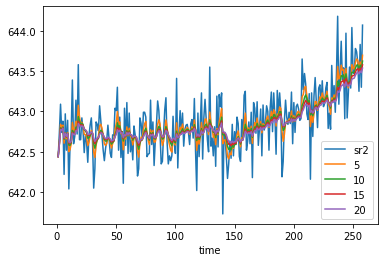

In [20]:
ax=pp.axes()
sensorTrace = trainData[FD001['idx']].loc[94,'sr2']
sensorTrace.plot(ax=ax)
ewma_span = 5
sensorTrace.ewm(span=ewma_span,ignore_na=True).mean().plot(ax=ax,label=str(ewma_span))
ewma_span = 10
sensorTrace.ewm(span=ewma_span,ignore_na=True).mean().plot(ax=ax,label=str(ewma_span))
ewma_span = 15
sensorTrace.ewm(span=ewma_span,ignore_na=True).mean().plot(ax=ax,label=str(ewma_span))
ewma_span = 20
sensorTrace.ewm(span=ewma_span,ignore_na=True).mean().plot(ax=ax,label=str(ewma_span))
ax.legend()

the exponentially weighted moving average, with span > 10 starts to lag substantially.

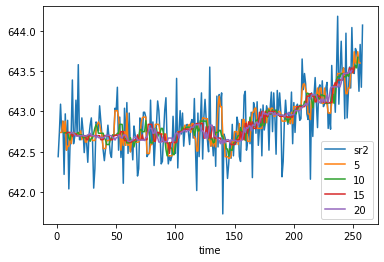

In [21]:
ax=pp.axes()
sensorTrace = trainData[FD001['idx']].loc[94,'sr2']
sensorTrace.plot(ax=ax)
span = 5
sensorTrace.rolling(window=span,center=True).median().plot(ax=ax,label=str(span))
span = 10
sensorTrace.rolling(window=span,center=True).median().plot(ax=ax,label=str(span))
span = 15
sensorTrace.rolling(window=span,center=True).median().plot(ax=ax,label=str(span))
span = 20
sensorTrace.rolling(window=span,center=True).median().plot(ax=ax,label=str(span))
ax.legend()

exponentially-weighted moving average with span 10 that looks ok. Only a little lag is induced...

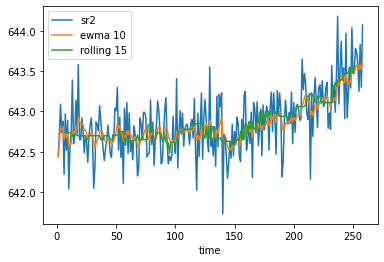

In [22]:
ax=pp.axes()
sensorTrace = trainData[FD001['idx']].loc[94,'sr2']
sensorTrace.plot(ax=ax)
ewma_span = 10
sensorTrace.ewm(span=ewma_span,ignore_na=True).mean().plot(ax=ax,label=('ewma ' + str(ewma_span)))
span = 15
sensorTrace.rolling(window=span,center=True).median().plot(ax=ax,label=('rolling ' +str(span)))
ax.legend()

I will apply ewma with span of 10 to the sensor readings. 

In [23]:
for i in range(len(meta)):
    ewma_span = 10
    # smoothing of train trajectories:
    for traject in range(1,meta[i]["Train trjectories:"]+1):
        traj = trainData[meta[i]['idx']].loc[traject,'sr2':].values
        for sr in range(traj.shape[1]):
            traj[:,sr] = pd.Series(data=traj[:,sr]).ewm(span=ewma_span,ignore_na=True).mean().values
        trainData[meta[i]['idx']].loc[traject,'sr2':] = traj
    # smoothing of test trajectories:
    for traject in range(1,meta[i]["Test trajectories:"]+1):
        traj = testData[meta[i]['idx']].loc[traject,'sr2':].values
        for sr in range(traj.shape[1]):
            traj[:,sr] = pd.Series(data=traj[:,sr]).ewm(span=ewma_span,ignore_na=True).mean().values
        testData[meta[i]['idx']].loc[traject,'sr2':] = traj

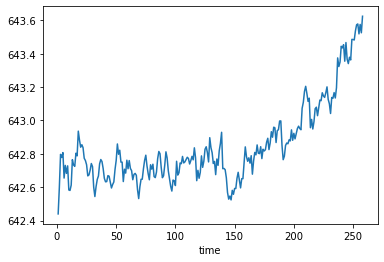

In [24]:
trainData[FD001['idx']].loc[94,'sr2'].plot()

In [25]:
for i in range(len(meta)):
    meta[i]['stats_train_smoothed'] = trainData[meta[i]['idx']].describe().T
    meta[i]['stats_test_smoothed'] = testData[meta[i]['idx']].describe().T

Now we will apply the normalization, dataset-wide

In [26]:
scaler = StandardScaler()

for i in range(len(meta)):
    # Fit on training set only.
    scaler.fit(trainData[meta[i]['idx']].loc[:,'sr2':])
    # Apply transform to both the training set and the test set.
    trainData[meta[i]['idx']].loc[:,'sr2':] = scaler.transform(trainData[meta[i]['idx']].loc[:,'sr2':])
    testData[meta[i]['idx']].loc[:,'sr2':] = scaler.transform(testData[meta[i]['idx']].loc[:,'sr2':])


In [27]:
trainData[meta[0]['idx']].describe().T

,count,mean,std,min,25%,50%,75%,max
op1,20631.0,-8.870147e-06,0.002187,-0.008700,-0.001500,0.000000,0.001500,0.008700
op2,20631.0,2.350831e-06,0.000293,-0.000600,-0.000200,0.000000,0.000300,0.000600
sr2,20631.0,6.035439e-14,1.000024,-3.103926,-0.741955,-0.102498,0.592190,3.139466
sr3,20631.0,3.618398e-14,1.000024,-3.770199,-0.727761,-0.116530,0.573314,3.608656
sr4,20631.0,-1.332384e-14,1.000024,-2.729108,-0.765971,-0.107436,0.604429,2.864253
sr7,20631.0,1.483757e-13,1.000024,-3.148148,-0.588785,0.073699,0.777007,2.579957
sr8,20631.0,7.414842e-12,1.000024,-2.796859,-0.772614,-0.030376,0.613682,3.465462
sr9,20631.0,-6.950187e-14,1.000024,-1.777052,-0.530894,-0.212457,0.181153,7.616409
sr11,20631.0,1.778862e-14,1.000024,-2.523765,-0.765113,-0.078624,0.585907,2.860250
sr12,20631.0,4.346766e-14,1.000024,-3.065616,-0.590508,0.063269,0.773219,2.208224


### the time reversal of the data sets

In [28]:
for i in range(len(meta)):
    # reverse the order of time in each trajectory
    for traject in range(1,meta[i]["Train trjectories:"]+1):
        traj = trainData[meta[i]['idx']].loc[traject,:].values
        trainData[meta[i]['idx']].loc[traject,:] = np.flipud(traj)


In [29]:
for i in range(len(meta)):
    # reverse the order of time in each trajectory
    for traject in range(1,meta[i]["Test trajectories:"]+1):
        traj = testData[meta[i]['idx']].loc[traject,:].values
        testData[meta[i]['idx']].loc[traject,:] = np.flipud(traj)

The time in the train and test dataset has now meaning of RUL+1 (remaining useful life, longer by one cycle)

In [30]:
# rename the index
for i in range(len(meta)):
    trainData[meta[i]['idx']].rename_axis(['unit','RUL+1'], inplace=True,axis=0)

In [31]:
trainData[FD001['idx']].head()

op1     op2       sr2       sr3       sr4       sr7       sr8  \
unit RUL+1                                                                     
1    1      0.0009 -0.0000  2.427180  2.053142  2.249795 -2.683360  2.981536   
     2     -0.0000 -0.0004  2.459229  1.963057  2.206693 -2.642136  2.829041   
     3     -0.0027  0.0001  2.612953  1.806636  2.195293 -2.494765  2.786317   
     4     -0.0006  0.0002  2.629007  1.768546  2.176165 -2.423386  2.698183   
     5     -0.0067  0.0003  2.339334  1.870695  2.093317 -2.162747  2.662294   

                 sr9      sr11      sr12      sr13      sr14      sr15  \
unit RUL+1                                                               
1    1     -1.190469  2.625742 -2.431022  3.136978 -1.601593  2.362671   
     2     -1.105237  2.525148 -2.496284  3.027667 -1.541612  2.368852   
     3     -1.108161  2.496512 -2.400156  2.964952 -1.515811  2.332003   
     4     -1.087261  2.291750 -2.444762  2.711079 -1.458068  2.251297   
     5     -1.106285  2.277267 -2.340634  2.471679 -1.451141  2.181774   

                sr17      sr20      sr21  
unit RUL+1                                
1    1      2.194905 -2.302527 -2.633685  
     2      2.146772 -2.283405 -2.375369  
     3      2.460943 -2.214078 -2.479279  
     4      2.098928 -2.190619 -2.448218  
     5      2.215967 -2.146628 -2.525486

# saving the fromated datasets

In [32]:
for i in range(len(meta)):
    trainData[meta[i]['idx']].to_csv('train_'+meta[i]["Data Set Name"]+'_smooth.csv',sep=' ')
    testData[meta[i]['idx']].to_csv('test_'+meta[i]["Data Set Name"]+'_smooth.csv',sep=' ')

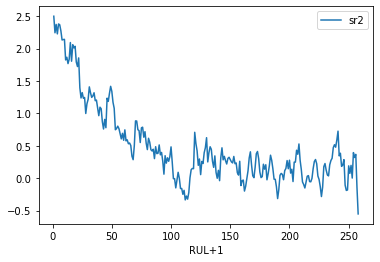

In [33]:
ax=pp.axes()
sensorTrace = trainData[FD001['idx']].loc[94,'sr2'].plot(ax=ax)
#ax.set_xlabel('RUL')
ax.legend()

In [34]:
def plot_trajectory(traj):
    trajT=traj.T
    rval = pp.pcolor(trajT, alpha=.75)
    #pp.cbar = pp.colorbar()
    #pp.cbar.solids.set_edgecolor("face")
    pp.yticks(np.arange(0.5, len(trajT.index), 1), trajT.index)
    pp.ylabel('parameter index')
    pp.xlabel('RUL')
    return rval

def plot_traj_ops (traj):
    fig, axs = pp.subplots(2, 1, figsize=(4, 6),sharex=True)
    trainData[FD001['idx']].loc[traj_idx,'op1':'op2'].plot(ax=axs[0])
    pcolor = plot_trajectory(traj.loc[:,'sr2':])
    return

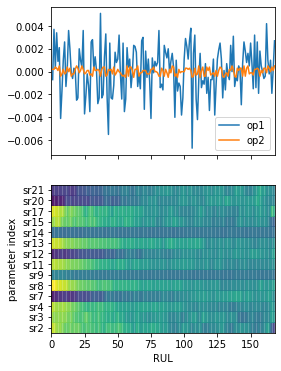

In [35]:
traj_idx = 23
plot_traj_ops(trainData[FD001['idx']].loc[traj_idx,:])

# Analysis of the engine failure pattern 

## sensor signals at the system failure

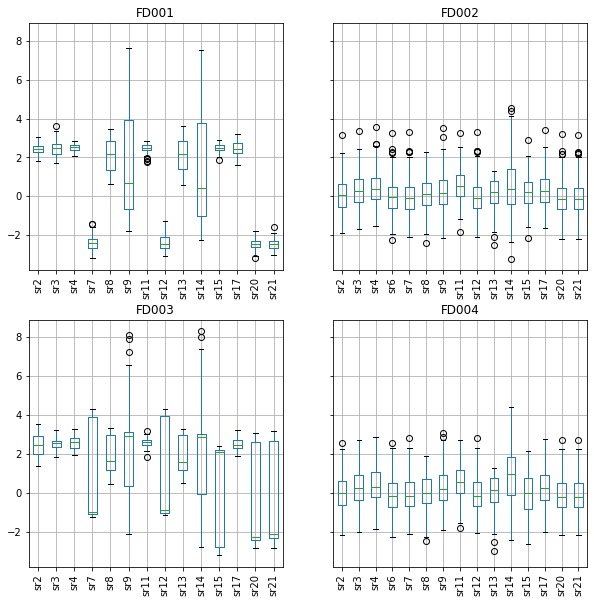

In [36]:
nrows=2
ncols=2
fig, ax = pp.subplots(figsize=(10,10),nrows=nrows, ncols=ncols, sharex=False, sharey=True,)
ax=ax.flatten()
for i in range(len(meta)):
    RUL=1
    fail_patterns = trainData[meta[i]['idx']].loc[:,'sr2':].xs(RUL,level='RUL+1')
    try:
        pd.plotting.boxplot(fail_patterns,ax=ax[i],rot=90)
    except:
        pass
    ax[i].set_title(meta[i]['Data Set Name'])

At the last cycle before system breakdown:
* norm. sensors sr7 , sr12, sr20 and sr21 are low, with median at -2.5 and low spread
* norm. sensors sr8 and sr13 have their medians about the same as those above, but higher spread (2x-3x higher) - less specific.
* norm. sensors sr2, sr3, sr4, sr11, sr15 and sr17 are high, with median about +2.5 and low spread
* norm. sensors sr9 and sr14 are the least specific, with median around 0.5 and span of the vaules across higher half of the range.

## sensor readings at the beginning of a trajectory

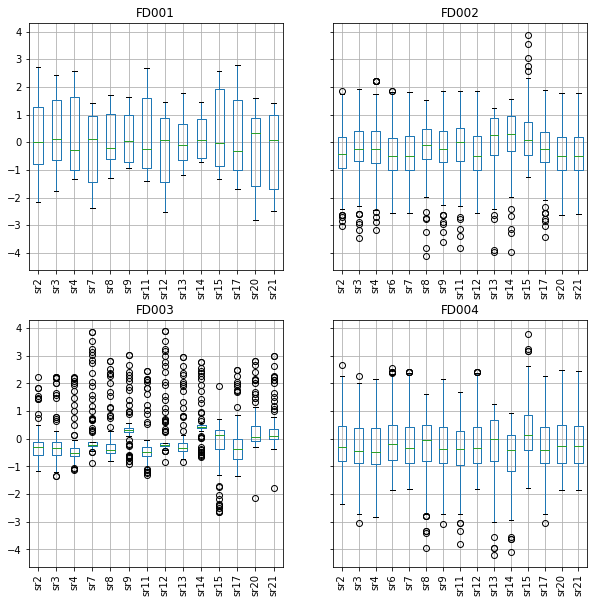

In [37]:
nrows=2
ncols=2
fig, ax = pp.subplots(figsize=(10,10),nrows=nrows, ncols=ncols, sharex=False, sharey=True,)
ax=ax.flatten()
for i in range(len(meta)):

    # get the indexes of the rows when the trajectory started
    starts = []
    RULS = trainData[meta[i]['idx']].index.get_level_values(level='RUL+1')
    for idx in range(len(RULS)):
        if idx+1 == len(RULS): 
            starts.append(RULS[idx])
            break
        if RULS[idx]>RULS[idx+1]:
            starts.append(RULS[idx])
    # select the readings of the sensors when the trajectory started
    start_patterns = trainData[meta[i]['idx']].loc[:,'sr2':].iloc[starts,:]
    pd.plotting.boxplot(start_patterns,ax=ax[i],rot=90)
    ax[i].set_title(meta[i]['Data Set Name'])

The readings of the sensors, when the trajectory started are all distributed with median close to 0. The distributions are very broadly distributed.
* the normalzied sensor readings sr8, sr9, sr13 and sr14 is the most narrowly spread with Q1-Q3 fitting within interval (-1, 1).

## sensor reading correlations

C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\ipykernel_launcher.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


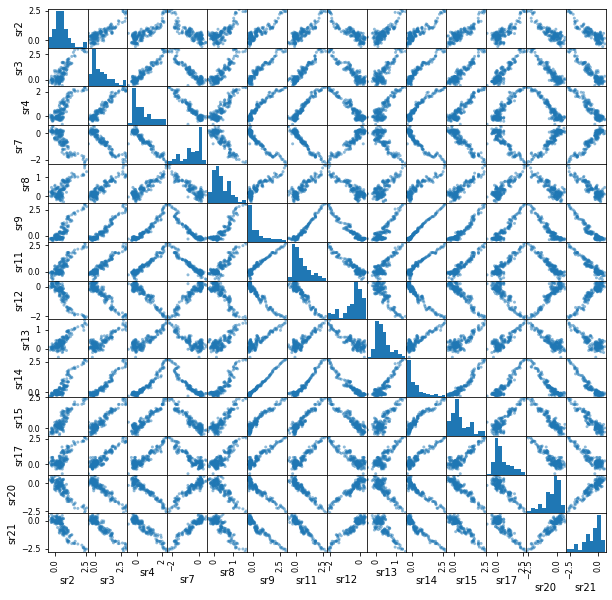

In [38]:
nrows=2
ncols=2
fig, ax = pp.subplots(figsize=(10,10),nrows=nrows, ncols=ncols, sharex=False, sharey=True,)
ax=ax.flatten()
for traj_idx in [3,5,88,14]:
    pd.plotting.scatter_matrix(trainData[FD001['idx']].loc[traj_idx,'sr2':],ax=ax[i]);

The sensor readings are highly correlated in trajectory 3

<Figure size 504x504 with 0 Axes>

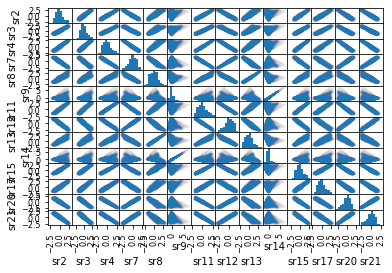

<Figure size 504x504 with 0 Axes>

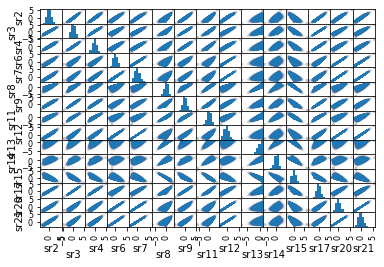

<Figure size 504x504 with 0 Axes>

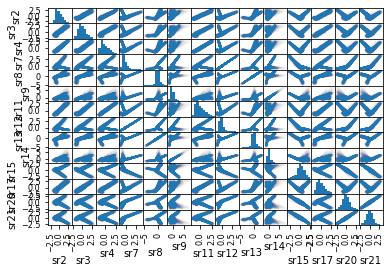

<Figure size 504x504 with 0 Axes>

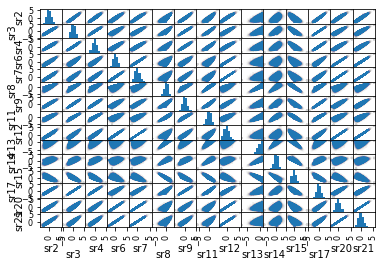

In [39]:
for i in range(len(meta)):
    fig=pp.figure(figsize=(7,7))
    pd.plotting.scatter_matrix(trainData[meta[i]['idx']].loc[:,'sr2':],alpha=0.003);

Most sensors in all traing dataset are almost perfectly correlated. Exceptions are:
* couples with sr9 or sr14 are correlated only partially with other parameters, probably through their absolute values
* sr9 and sr14 are 
* the correlations are less perfect for couples with sr8 or sr13